# Notebook for non-kernel models

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    make_scorer,
    fbeta_score,
    accuracy_score,
    roc_auc_score,
)

from scripts.nested_CV import nested_cv, nested_cv_multi

In [10]:
# configs
seed = 42  # for repeatability

fbeta_scorer = make_scorer(fbeta_score, beta=2)
accuracy_scorer = make_scorer(accuracy_score)
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)

score_dict = {
    "f2": fbeta_scorer,
    "roc_auc": roc_auc_scorer,
    "accuracy": accuracy_scorer,
}

c:\Users\haani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


### Data import and preprocessing

In [11]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)
y_flipped = y * -1

print(X.shape, y.shape)

(200, 60) (200,)


#### Normalization
Z score normalization is applied to each instance. This is done, incase some samples have a different frequency specification, which we don't want our models to learn. Instead we just want to look at the relative $\Delta$ between time stamps.

The zscore normalization is defined as follows:

$$
z = \frac {x - \bar{x}}{\sigma}  \text \space \newline where, \bar{x} = \text{mean} \space and \space \sigma = \text{standard deviation}
$$

In [12]:
# normalizing the data and splitting into train/test splits
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

## Tuning and Evaluation

### Metric
We would like to tune the hyperparameters for the $f_{\beta}$ (formula given below) score of the negative class, with $\beta > 1$ (i.e. recall is more important than precision), under the assumption that shipping a medical grade laser is more expensive than re-testing and/or repairing it. Therefore, it's better to identify as many faulty lasers as possible, even if it means re-testing some positive ones.

However, there is a caveat to this approach. $f$-measures are sensitive to class imbalance, and in the real world we can assume that faulty lasers would be rarer, which is not the case with the dataset provided. Therefore, tuning for $f_{\beta}$ is only a good idea in a vacuum and in the context of this project, where the both the test and training splits have balanced classes. In the real world, given more data and also more varied data, ROC AUC (explanation below) would be a much better metric, as it finds out the better model overall. It would be even better to use ROC AUC in conjunction with giving a higher penalty to faulty lasers classified as non-faulty (False negatives). Furthermore, it was also discovered when employing ROC AUC on this toy dataset that extreme hyperparameters were chosen, by the nested cross validation loop - indicating overfitting, possibly due to the lack of enough data and not enough variety. Therefore, ultimately a choice was made to go with $f_{\beta}$ for hyperparameter tuning and evaluation.

**F2 Measure**
$$
f_{\beta} =\frac {\beta^{2} + 1}  {\beta^{2} \cdot recall^{-1} + precision^{-1}} = \frac {1+\beta^{2} \cdot precision \cdot recall} {(\beta^{2} \cdot precision) + recall} 
\newline
$$

**ROC AUC** <br>
ROC AUC is calculated by computing the area under the curve of TPR (recall) v/s FPR
$$
r_{TP} = \frac{n_{TP}}{n_{TP} + n_{FN}} \space \text{and} \space
r_{FP} = \frac{n_{FP}}{n_{FP}+n_{TN}}
$$

#### Nested Cross Validation
Here is a visual explanation of nested cross validation: <br>
![image](../diagrams/nested.jpg)

The `nested_cv` function performs nested cross validation, with (by default) 5 outer and 5 inner loops and is abstracted away at `src/scripts/nested_CV.py`

## Baseline: Logistic Regression

### Description
Regression, that uses the sigmoid function as the decision function to classify instances. It uses the logistic loss and we use the L2 penalty here.

Sigmoid function:
$$
f_{\theta}(x) = \frac {1}{1+e^{-x}}
$$

Logistic loss:
$$
\mathcal{l}_{\text log}(f_{\theta (x_{\text i}), y_{\text i}}) = log(1+e^{-y_{i} f_{\theta}(x_{i})})

$$

In [13]:
param_grid_log = {"C": np.logspace(-3, 3, 7)}
results = nested_cv_multi(
    LogisticRegression(penalty="l2"),
    X,
    y_flipped,
    param_grid=param_grid_log,
    scoring=score_dict,
    random_state=seed,
)

print(">>>>RESULTS<<<<")
print(
    "Mean scores over 5 by 5 rounds of Nested CV ",
    results["mean_scores"],
)
print("Best parameters ", results["star_params"])

>>>>RESULTS<<<<
Mean scores over 5 by 5 rounds of Nested CV  {'f2': 0.9193507586052723, 'roc_auc': 0.9630000000000001, 'accuracy': 0.9199999999999999}
Best parameters  {'C': 0.1}


In [14]:
print(results)

{'outer_scores': [{'f2': 0.8585858585858586, 'roc_auc': 0.9675, 'accuracy': 0.875}, {'f2': 0.8585858585858586, 'roc_auc': 0.9199999999999999, 'accuracy': 0.875}, {'f2': 0.9900990099009901, 'roc_auc': 1.0, 'accuracy': 0.975}, {'f2': 0.9803921568627451, 'roc_auc': 0.95, 'accuracy': 0.95}, {'f2': 0.9090909090909091, 'roc_auc': 0.9775, 'accuracy': 0.925}], 'mean_scores': {'f2': 0.9193507586052723, 'roc_auc': 0.9630000000000001, 'accuracy': 0.9199999999999999}, 'std_scores': {'f2': 0.05695854285956674, 'roc_auc': 0.026897955312625562, 'accuracy': 0.03999999999999999}, 'best_params': [{'C': 1000.0}, {'C': 10.0}, {'C': 0.1}, {'C': 1.0}, {'C': 0.1}], 'star_params': {'C': 0.1}}


In [15]:
clf_log = LogisticRegression(C=0.1)
clf_log.fit(np.delete(X, [35, 162], axis=0), np.delete(y_flipped, [35, 162], axis=0))

odd_laser_faulty = clf_log.predict([X[35]])
odd_laser_non_faulty = clf_log.predict([X[162]])
print(odd_laser_faulty, odd_laser_non_faulty)

[1] [1]


## BUT ..... 

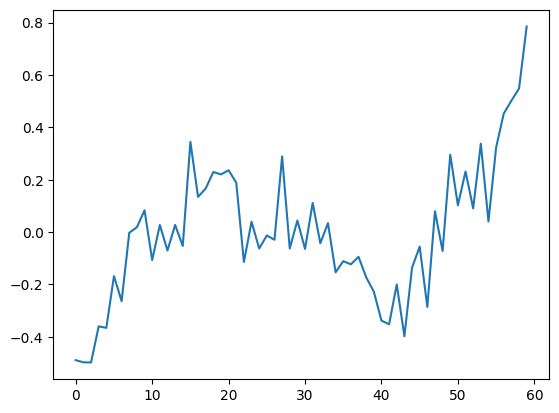

In [16]:
plt.plot(clf_log.coef_[0])